In [316]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

width = 12
height = 7
plt.rcParams["figure.figsize"] = (width, height)

import pandas as pd
import numpy as np
import tflscripts
from tflscripts import boxplot_by, scatter_plot_by, heatmap_by
import matplotlib.patches as mpatches
import json
import pickle
import seaborn as sns

configuration = tflscripts.read_configuration()
specificity_type = 'r'

df = pd.read_pickle('results_with_accuracy_classified_sr_non_random-f1.p')
df = df.loc[df.first_predictions >= 0]

# for within device transfer, only use Mites
df = df.loc[((df.source_device_type == 'Mite') & (df.target_device_type == 'Mite') | (df.source_device_type != df.target_device_type))]


df['type_of_transfer'] = df.type_of_transfer.map({
    'Same device type in same place': 'A: replica',
    'Same device type in different place': 'B: placement',
    'Same device in different place': 'B: placement',
    'Same device type across spaces': 'C: room',
    'Same device across spaces': 'C: room',
    'Different device in same place': 'D: sensor board',
    'Same device in same place': 'A: replica',
    'Different device in different place': '__remove__',
    'Different device across spaces': '__remove__',
    'No transfer': 'No transfer'
})

In [317]:
# performance metrics of the recommendations

source_threshold = 0.75
threshold = 0.93
specificity_column = 'specificity_for_retrained'

df['recommended'] = False
df.loc[(df.f1_wt >= source_threshold) & (df[specificity_column] >= threshold) & (df.predictions > 0), 'recommended'] = True

In [320]:
def to_target_type_key(row):
    columns =  ['target_placement', 'target_room', 'target_device_type', 'label']
    return '_'.join(row[columns])

df['target_type_key'] = [to_target_type_key(row) for i, row in df.iterrows()]

In [356]:
df = df.loc[~((df.type_of_transfer == 'A: replica') & (df.label == 'Soap dispensed') & (df.recommended == True))]

In [357]:
possible_activities = df.loc[(df.classifier == 'SVM') & (df.features_name == 'All')]

possible_activities = possible_activities.sort_values(by=['f1_target_wt'], ascending=False)
possible_activities = possible_activities.drop_duplicates([
    'target_placement', 'target_room', 'target_device_type', 'label'
], keep='first')
possible_activities = possible_activities[possible_activities.f1_target_wt >= 0.75]

possible_keys = possible_activities.target_type_key.unique()
df = df.loc[df.target_type_key.isin(possible_keys)]
# df = df.loc[df.source_key.isin(possible_activities.target_key)]

In [358]:
possible_activities.loc[(possible_activities.label == 'Chopping food') & (possible_activities.target_placement == 'Sink')].target_type_key

24759     Sink_robotics_Mite_Chopping food
29097      Sink_synergy_Mite_Chopping food
34305    Sink_synergy_Matrix_Chopping food
Name: target_type_key, dtype: object

In [359]:
recognizable_activities = possible_activities[['label', 'target_room', 'target_placement', 'target_device_type']]
# recognizable_activities.columns = ['label', 'room', 'placement', 'device_type']

In [360]:
transfers = df.drop_duplicates(['transfer_key'])[['source_placement', 'target_placement', 'source_room', 'target_room', 'source_device_type', 'target_device_type', 'type_of_transfer']]
activity_transfers = pd.merge(transfers, recognizable_activities, on=['target_room', 'target_placement', 'target_device_type'])

# merge to get f1_target_wt
activity_transfers = pd.merge(activity_transfers,
                              possible_activities[['target_placement', 'target_room', 'target_device_type', 'label', 'f1_target_wt']],
                              on=['target_placement', 'target_room', 'target_device_type', 'label'])

In [414]:
transfers.loc[(transfers.type_of_transfer == 'D: sensor board')]

,source_placement,target_placement,source_room,target_room,source_device_type,target_device_type,type_of_transfer
594,Coffee,Coffee,robotics,robotics,Mite,XDK,D: sensor board
1225,Sink,Sink,robotics,robotics,Mite,Matrix,D: sensor board
1360,Sink,Sink,robotics,robotics,Mite,XDK,D: sensor board
1971,Entrance,Entrance,robotics,robotics,Mite,Matrix,D: sensor board
2116,Entrance,Entrance,robotics,robotics,Mite,XDK,D: sensor board
2241,Coffee,Coffee,robotics,robotics,Matrix,Mite,D: sensor board
2457,Coffee,Coffee,robotics,robotics,Matrix,XDK,D: sensor board
2565,Sink,Sink,robotics,robotics,Matrix,Mite,D: sensor board
2845,Sink,Sink,robotics,robotics,Matrix,XDK,D: sensor board
2970,Entrance,Entrance,robotics,robotics,Matrix,Mite,D: sensor board


In [361]:
above_source_threshold = df.loc[df.f1_wt >= source_threshold]
# above_specificity_threshold = above_source_threshold.loc[above_source_threshold[specificity_column] >= threshold]
recommended = above_source_threshold.loc[(above_source_threshold.first_predictions == 1) & (above_source_threshold.predictions > 0)]

drop_duplicates_by = ['transfer_with_label_key']

single_recommended = recommended.sort_values(by=['predictions', specificity_column, 'f1'], ascending=False)
single_recommended = single_recommended.drop_duplicates(drop_duplicates_by, keep='first')

ideal = df.loc[df.f1 >= 0.75]
ideal = ideal.sort_values(by=['f1'], ascending=False)
ideal = ideal.drop_duplicates(drop_duplicates_by, keep='first')

In [362]:
sr = single_recommended.copy().rename(columns={specificity_column: 'specificity_recommended'})
complete = pd.merge(activity_transfers,
         sr[['source_placement', 'source_room', 'source_device_type', 'target_placement', 'target_room', 'target_device_type', 'label', 'f1', 'specificity_recommended']],
         how='left',
         on=['source_placement', 'source_room', 'source_device_type', 'target_placement', 'target_room', 'target_device_type', 'label'])

In [363]:
same_model = df.loc[(df.classifier == 'SVM') & (df.features_name == 'All')].drop_duplicates(drop_duplicates_by, keep='first')
same_model = same_model.copy().rename(columns={'f1': 'f1_same_model'})
complete = pd.merge(complete,
         same_model[['source_placement', 'source_room', 'source_device_type', 'target_placement', 'target_room', 'target_device_type', 'label', 'f1_same_model']],
         how='left',
         on=['source_placement', 'source_room', 'source_device_type', 'target_placement', 'target_room', 'target_device_type', 'label'])

In [364]:
best = df.sort_values(by=['f1'], ascending=False)
best = best.drop_duplicates(drop_duplicates_by, keep='first')
best = best.copy().rename(columns={'f1': 'f1_best', specificity_column: 'specificity_best'})
complete = pd.merge(complete,
         best[['source_placement', 'source_room', 'source_device_type', 'target_placement', 'target_room', 'target_device_type', 'label', 'f1_best', 'specificity_best']],
         how='left',
         on=['source_placement', 'source_room', 'source_device_type', 'target_placement', 'target_room', 'target_device_type', 'label'])

In [365]:
short_activities = ['Microwave door closed', 'Knocking', 'Cupboard door closed',
       'Cupboard door opened', 'Soap dispensed', 'Microwave button press',
       'Microwave done chime']

complete['training_time'] = [3 if row['label'] in short_activities else 6 for _, row in complete.iterrows()]

In [366]:
complete['recommended'] = (~np.isnan(complete.f1)) & (complete.specificity_recommended >= threshold)
complete['should_recommend_spec'] = [row['f1_best'] >= 0.75 and row['specificity_best'] >= threshold for _, row in complete.iterrows()]
complete['should_recommend'] = [row['f1_best'] >= 0.75 for _, row in complete.iterrows()]

usable = complete.loc[(complete.type_of_transfer != 'C: room') | ((complete.source_room != 'robotics') & (complete.target_room != 'robotics'))]
usable = usable.loc[(usable.type_of_transfer != 'B: placement') | (usable.source_room == 'synergy')]
usable = usable.loc[(usable.type_of_transfer != 'D: sensor board') | ((usable.source_room == 'scott') | (usable.source_placement == 'Coffee'))]

In [367]:
sizes_for_transferred = usable.loc[usable.recommended].groupby(['source_placement', 'source_room', 'source_device_type', 'target_placement', 'target_room', 'target_device_type', 'type_of_transfer']).size()
sizes_for_all = usable.groupby(['source_placement', 'source_room', 'source_device_type', 'target_placement', 'target_room', 'target_device_type', 'type_of_transfer']).size()

transferred_proportions = (sizes_for_transferred / sizes_for_all).reset_index()
transferred_proportions = transferred_proportions.rename(columns={0: 'percentage_transferred'})
transferred_proportions = transferred_proportions.fillna(0)

# Coverage

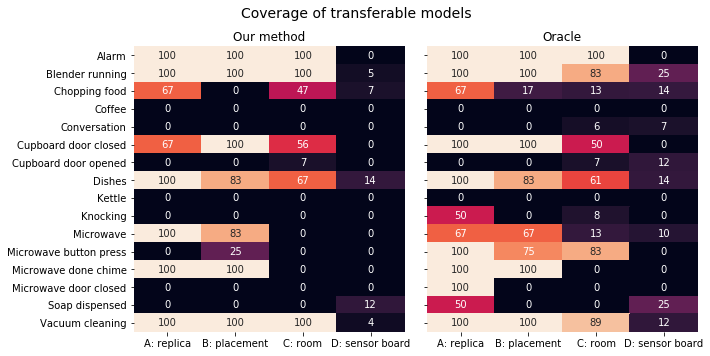

In [368]:
plt.rcParams["figure.figsize"] = (10, 5)

fig, axes = plt.subplots(1, 2, sharex=False, sharey=True)

usable['available'] = [1 for i in np.isnan(usable.f1)]
transferability_by_activities = pd.DataFrame(usable.groupby(['type_of_transfer', 'label'])['recommended'].sum() / usable.groupby(['type_of_transfer', 'label'])['available'].sum()).reset_index()

sns.heatmap(
    transferability_by_activities.pivot(index='label', columns='type_of_transfer', values=0).fillna(0) * 100,
    ax=axes[0],
    annot=True, fmt='.0f',
    cbar=False,
    cbar_ax=None
)

transferability_by_activities = pd.DataFrame(usable.groupby(['type_of_transfer', 'label'])['should_recommend_spec'].sum() / usable.groupby(['type_of_transfer', 'label'])['available'].sum()).reset_index()

plt.rcParams["figure.figsize"] = (6, 5)
sns.heatmap(
    transferability_by_activities.pivot(index='label', columns='type_of_transfer', values=0).fillna(0) * 100,
    ax=axes[1],
    annot=True, fmt='.0f',
    cbar=False
)

axes[0].set_title('Our method')
axes[1].set_title('Oracle')

axes[0].set_ylabel('')
axes[0].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_xlabel('')

plt.suptitle('Coverage of transferable models', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.87)

plt.savefig('../plots/coverage_heatmap.pdf')
plt.show()

In [369]:
import seaborn as sns
plt.rcParams["figure.figsize"] = (8, 4)

r = transferred_proportions

replica = r.loc[r.type_of_transfer == 'A: replica']
placement = r.loc[r.type_of_transfer == 'B: placement']
room = r.loc[r.type_of_transfer == 'C: room']
sensor_board = r.loc[r.type_of_transfer == 'D: sensor board']

print('Coverage')
print('replica', round(replica.percentage_transferred.mean(), 2), round(replica.percentage_transferred.std(), 2))
print('placement', round(placement.percentage_transferred.mean(), 2), round(placement.percentage_transferred.std(), 2))
print('room', round(room.percentage_transferred.mean(), 2), round(room.percentage_transferred.std(), 2))
print('sensor_board', round(sensor_board.percentage_transferred.mean(), 2), round(sensor_board.percentage_transferred.std(), 2))

Coverage
replica 0.53 0.03
placement 0.49 0.06
room 0.41 0.08
sensor_board 0.05 0.11


In [385]:
print('Activities transferred')
number_transferred = usable.loc[usable.recommended].groupby(['source_placement', 'source_room', 'source_device_type', 'target_placement', 'target_room', 'target_device_type', 'type_of_transfer']).size()
number_transferred = number_transferred.reset_index()
number_transferred.groupby(['type_of_transfer'])[0].mean().round()
# number_transferred.loc[number_transferred.type_of_transfer == 'A: replica']

Activities transferred


type_of_transfer
A: replica         7.0
B: placement       6.0
C: room            5.0
D: sensor board    1.0
Name: 0, dtype: float64

In [388]:
print('Out of all activities')
number_transferred = usable.groupby(['source_placement', 'source_room', 'source_device_type', 'target_placement', 'target_room', 'target_device_type', 'type_of_transfer']).size()
number_transferred = number_transferred.reset_index()
number_transferred.groupby(['type_of_transfer'])[0].mean().round()
# number_transferred.loc[number_transferred.type_of_transfer == 'A: replica']

Out of all activities


type_of_transfer
A: replica         13.0
B: placement       13.0
C: room            12.0
D: sensor board     6.0
Name: 0, dtype: float64

In [389]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, f1_score, precision_score, recall_score

to_use = usable

print('Accuracy', accuracy_score(to_use['should_recommend'], to_use['recommended']))
print('F1', f1_score(to_use['should_recommend'], to_use['recommended']))
print('Precision', precision_score(to_use['should_recommend'], to_use['recommended']))
print('Recall', recall_score(to_use['should_recommend'], to_use['recommended']))
shouldnt_recommned = to_use.loc[to_use.should_recommend == False]

print('Specificity', accuracy_score(shouldnt_recommned['should_recommend'], shouldnt_recommned['recommended']))

Accuracy 0.879275653924
F1 0.8125
Precision 0.878378378378
Recall 0.755813953488
Specificity 0.944615384615


In [373]:
r = usable

replica = r.loc[r.type_of_transfer == 'A: replica']
placement = r.loc[r.type_of_transfer == 'B: placement']
room = r.loc[r.type_of_transfer == 'C: room']
sensor_board = r.loc[r.type_of_transfer == 'D: sensor board']

print('Replica accuracy', accuracy_score(replica['should_recommend'], replica['recommended']))
print('Placement accuracy', accuracy_score(placement['should_recommend'], placement['recommended']))
print('Room accuracy', accuracy_score(room['should_recommend'], room['recommended']))
print('Sensor board accuracy', accuracy_score(sensor_board['should_recommend'], sensor_board['recommended']))

Replica accuracy 0.815789473684
Placement accuracy 0.921052631579
Room accuracy 0.859154929577
Sensor board accuracy 0.9


# Saved effort in minutes

In [390]:
time_transferred = usable.loc[usable.recommended].groupby(['source_placement', 'source_room', 'source_device_type', 'target_placement', 'target_room', 'target_device_type', 'type_of_transfer'])['training_time'].sum()
time_transferred = time_transferred.reset_index()
time_transferred.groupby(['type_of_transfer'])['training_time'].mean().round()
# number_transferred.loc[number_transferred.type_of_transfer == 'A: replica']

type_of_transfer
A: replica         37.0
B: placement       32.0
C: room            26.0
D: sensor board     8.0
Name: training_time, dtype: float64

In [391]:
time_transferred = usable.groupby(['source_placement', 'source_room', 'source_device_type', 'target_placement', 'target_room', 'target_device_type', 'type_of_transfer'])['training_time'].sum()
time_transferred = time_transferred.reset_index()
time_transferred.groupby(['type_of_transfer'])['training_time'].mean().round()
# number_transferred.loc[number_transferred.type_of_transfer == 'A: replica']

type_of_transfer
A: replica         62.0
B: placement       62.0
C: room            58.0
D: sensor board    32.0
Name: training_time, dtype: float64

# Performance

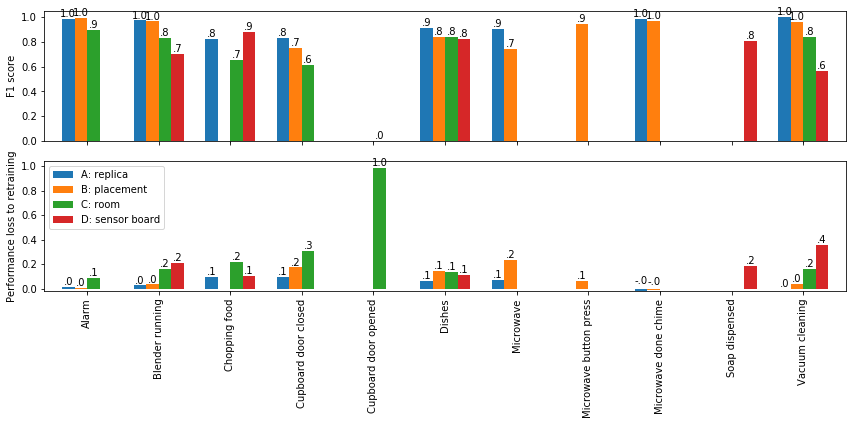

In [392]:
def _remove_leading_zero(value, string):
    if 1 > value > -1:
        string = string.replace('0', '', 1)
    return string


class MyFloat(float):
    def __str__(self):
        string = super().__str__()
        return _remove_leading_zero(self, string)

    def __format__(self, format_string):
        string = super().__format__(format_string)
        return _remove_leading_zero(self, string)

plt.rcParams["figure.figsize"] = (12, 6)

fig, axes = plt.subplots(2, 1, sharex=True, sharey=False)

r = usable.loc[usable.recommended].copy()
# r.groupby(['type_of_transfer', 'label'])['performance_loss'].mean().plot.bar()
r = pd.DataFrame(r.groupby(['type_of_transfer', 'label'])['f1'].mean()).reset_index()
# sns.heatmap(r.pivot(index='label', columns='type_of_transfer', values='performance_loss'))
r = r.pivot(index='label', columns='type_of_transfer', values='f1')
ax = r.plot.bar(width=0.7, ax=axes[0])
ax.legend().set_title('')
ax.set_xlabel('')

rects = ax.patches

i = 0
for transfer in r.columns:
    for activity in r.index:
        rect = rects[i]
        i += 1
        val = r[transfer][activity]
        height = rect.get_height()
        if not np.isnan(val):
            val = np.round(val, 1)
            val = MyFloat(val)
            ax.text(rect.get_x() + rect.get_width()/2, height, val, ha='center', va='bottom')

ax.set_ylabel('F1 score')
ax.legend_.remove()

r = usable.loc[usable.recommended].copy()
r['performance_loss'] = r.f1_target_wt - r.f1
# r.groupby(['type_of_transfer', 'label'])['performance_loss'].mean().plot.bar()
r = pd.DataFrame(r.groupby(['type_of_transfer', 'label'])['performance_loss'].mean()).reset_index()
# sns.heatmap(r.pivot(index='label', columns='type_of_transfer', values='performance_loss'))
r = r.pivot(index='label', columns='type_of_transfer', values='performance_loss')
ax = r.plot.bar(width=0.7, ax=axes[1])
ax.legend().set_title('')
ax.set_xlabel('')

rects = ax.patches

i = 0
for transfer in r.columns:
    for activity in r.index:
        rect = rects[i]
        i += 1
        val = r[transfer][activity]
        height = rect.get_height()
        if not np.isnan(val):
            val = np.round(val, 1)
            val = MyFloat(val)
            ax.text(rect.get_x() + rect.get_width()/2, height, val, ha='center', va='bottom')

ax.set_ylabel('Performance loss to retraining')
ax.legend(loc=2)
plt.tight_layout()

plt.savefig('../plots/activity_performance_loss.pdf')
plt.show()

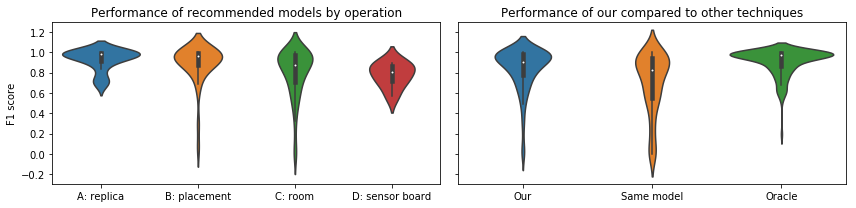

In [397]:
plt.rcParams["figure.figsize"] = (12, 3)

fig, axes = plt.subplots(1, 2, sharex=False, sharey=True)

r = usable.loc[usable.recommended].copy()
r['performance_loss'] = r.f1_target_wt - r.f1

replica = r.loc[r.type_of_transfer == 'A: replica']
placement = r.loc[(r.type_of_transfer == 'B: placement')]
room = r.loc[r.type_of_transfer == 'C: room']
sensor_board = r.loc[r.type_of_transfer == 'D: sensor board']

ax = sns.violinplot(x='Step', y='F1 score',
    data=pd.concat([
        pd.DataFrame({
            'Step': 'A: replica',
            'F1 score': replica.f1
        }),
        pd.DataFrame({
            'Step': 'B: placement',
            'F1 score': placement.f1
        }),
        pd.DataFrame({
            'Step': 'C: room',
            'F1 score': room.f1
        }),
        pd.DataFrame({
            'Step': 'D: sensor board',
            'F1 score': sensor_board.f1
        })
    ]), ax=axes[0])
ax.set_title('Performance of recommended models by operation')

ax.set_xlabel('')
ax.set_ylabel('F1 score')

ax = sns.violinplot(x='Step', y='F1 score',
    data=pd.concat([
        pd.DataFrame({
            'Step': 'Our',
            'F1 score': r.f1
        }),
        pd.DataFrame({
            'Step': 'Same model',
            'F1 score': r.f1_same_model
        }),
        pd.DataFrame({
            'Step': 'Oracle',
            'F1 score': r.f1_best
        }),
#         pd.DataFrame({
#             'Step': 'Retraining',
#             'F1': r.f1_target_wt
#         })
    ]), ax=axes[1])
ax.set_title('Performance of our compared to other techniques')

ax.set_xlabel('')
ax.set_ylabel('')

plt.tight_layout()

plt.savefig('../plots/performance_distributions.pdf')
plt.show()

In [394]:
r = usable.loc[usable.recommended].copy()
r['performance_loss_retraining'] = r.f1_target_wt - r.f1
r['performance_loss_same'] = r.f1_same_model - r.f1
r['performance_loss_best'] = r.f1_best - r.f1

replica = r.loc[r.type_of_transfer == 'A: replica']
placement = r.loc[(r.type_of_transfer == 'B: placement')]
room = r.loc[r.type_of_transfer == 'C: room']
sensor_board = r.loc[r.type_of_transfer == 'D: sensor board']

def m(series):
    return series.mean()

medians = pd.DataFrame([
    [m(replica.performance_loss_retraining), m(replica.performance_loss_same), m(replica.performance_loss_best)],
    [m(placement.performance_loss_retraining), m(placement.performance_loss_same), m(placement.performance_loss_best)],
    [m(room.performance_loss_retraining), m(room.performance_loss_same), m(room.performance_loss_best)],
    [m(sensor_board.performance_loss_retraining), m(sensor_board.performance_loss_same), m(sensor_board.performance_loss_best)],
    [m(r.performance_loss_retraining), m(r.performance_loss_same), m(r.performance_loss_best)]
])
stds = pd.DataFrame([
    [replica.performance_loss_retraining.std(), replica.performance_loss_same.std(), replica.performance_loss_best.std()],
    [placement.performance_loss_retraining.std(), placement.performance_loss_same.std(), placement.performance_loss_best.std()],
    [room.performance_loss_retraining.std(), room.performance_loss_same.std(), room.performance_loss_best.std()],
    [sensor_board.performance_loss_retraining.std(), sensor_board.performance_loss_same.std(), sensor_board.performance_loss_best.std()],
    [r.performance_loss_retraining.std(), r.performance_loss_same.std(), r.performance_loss_best.std()]
])
medians.columns = ['Retraining', 'Same model', 'Oracle']
medians.index = ['Replica', 'Placement', 'Room', 'Sensor board', 'Combined']
stds.columns = ['Retraining', 'Same model', 'Oracle']
stds.index = ['Replica', 'Placement', 'Room', 'Sensor board', 'Combined']
medians.round(2), stds.round(2)

(              Retraining  Same model  Oracle
 Replica             0.04       -0.08    0.03
 Placement           0.09       -0.16    0.06
 Room                0.17       -0.16    0.08
 Sensor board        0.17       -0.01    0.09
 Combined            0.14       -0.14    0.07,
               Retraining  Same model  Oracle
 Replica             0.08        0.22    0.06
 Placement           0.18        0.25    0.16
 Room                0.22        0.22    0.15
 Sensor board        0.09        0.23    0.06
 Combined            0.20        0.23    0.14)

In [395]:
print('Overall F1 score')

print("Naive", np.round(usable.f1_same_model.median(), 2), usable.f1_same_model.std())
only_recommended = usable.loc[usable.recommended]
print("Our", np.round(only_recommended.f1.median(), 2), only_recommended.f1.std())
print("Same model", np.round(only_recommended.f1_same_model.median(), 2), only_recommended.f1_same_model.std())
print("Oracle", np.round(only_recommended.f1_best.median(), 2), only_recommended.f1_best.std())

Overall F1 score
Naive 0.32 0.336392896393
Our 0.91 0.215028181386
Same model 0.82 0.299444447815
Oracle 0.97 0.128511940095


replica 0.98 0.1
placement 0.96 0.19
room 0.87 0.24
sensor_board 0.8 0.12


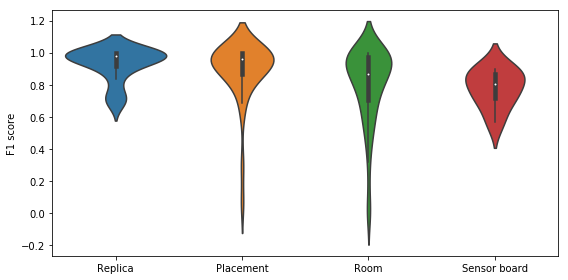

In [396]:
import seaborn as sns
plt.rcParams["figure.figsize"] = (8, 4)

r = usable.loc[usable.recommended]
# r = r.loc[r.target_room == 'synergy']

replica = r.loc[r.type_of_transfer == 'A: replica']
placement = r.loc[r.type_of_transfer == 'B: placement']
room = r.loc[r.type_of_transfer == 'C: room']
sensor_board = r.loc[r.type_of_transfer == 'D: sensor board']

ax = sns.violinplot(x='Step', y='F1 score',
    data=pd.concat([
        pd.DataFrame({
            'Step': 'Replica',
            'F1 score': replica.f1
        }),
        pd.DataFrame({
            'Step': 'Placement',
            'F1 score': placement.f1
        }),
        pd.DataFrame({
            'Step': 'Room',
            'F1 score': room.f1
        }),
        pd.DataFrame({
            'Step': 'Sensor board',
            'F1 score': sensor_board.f1
        })
    ]))
plt.xlabel('')

print('replica', round(replica.f1.median(), 2), round(replica.f1.std(), 2))
print('placement', round(placement.f1.median(), 2), round(placement.f1.std(), 2))
print('room', round(room.f1.median(), 2), round(room.f1.std(), 2))
print('sensor_board', round(sensor_board.f1.median(), 2), round(sensor_board.f1.std(), 2))

plt.tight_layout()

# Number of activities used for testing specificity

In [419]:
df.groupby(['type_of_transfer'])['num_activities_for_specificity'].mean().round()

type_of_transfer
A: replica         4.0
B: placement       6.0
C: room            6.0
D: sensor board    8.0
No transfer        2.0
Name: num_activities_for_specificity, dtype: float64

In [382]:
df.num_activities_for_specificity.median()

6.0

In [383]:
df.loc[(df.target_room == 'synergy') &
        (df.target_placement == 'Sink') &
      (df.type_of_transfer == 'A: replica') &
      (df.label == 'Chopping food')]
# complete.loc[(complete.target_room == 'synergy') &
#         (complete.target_placement == 'Sink') &
#       (complete.type_of_transfer == 'A: replica') &
#       (complete.label == 'Chopping food')]
possible_activities.loc[(possible_activities.label == 'Chopping food') & (possible_activities.target_placement == 'Sink')].target_type_key

24759     Sink_robotics_Mite_Chopping food
29097      Sink_synergy_Mite_Chopping food
34305    Sink_synergy_Matrix_Chopping food
Name: target_type_key, dtype: object

# Selected operations

In [400]:
# replica case: Sink, synergy, Mite

def report(type_of_transfer, source_placement, source_room=None, target_room=None, target_placement=None, source_device_type=None, target_device_type=None):
    selected = usable.loc[(usable.type_of_transfer == type_of_transfer) & (usable.source_placement == source_placement)]
    if source_room is not None:
        selected = selected.loc[(selected.source_room == source_room)]
    if target_room is not None:
        selected = selected.loc[(selected.target_room == target_room)]
    if target_placement is not None:
        selected = selected.loc[(selected.target_placement == target_placement)]
    if source_device_type is not None:
        selected = selected.loc[(selected.source_device_type == source_device_type)]
    if target_device_type is not None:
        selected = selected.loc[(selected.target_device_type == target_device_type)]

    print(type_of_transfer)
    print('Recommended', len(selected.loc[selected.recommended]), 'out of', len(selected))
    short = selected.loc[selected.training_time == 3]
    long = selected.loc[selected.training_time == 6]
    recommended = selected.loc[selected.recommended]
    short_recommended = recommended.loc[selected.training_time == 3]
    long_recommended = recommended.loc[selected.training_time == 6]
    print('Activities', recommended.label.unique())
    print('F1', recommended.f1)
    print('Recommended short', len(short_recommended), 'out of', len(short))
    print('Recommended long', len(long_recommended), 'out of', len(long))
    print('Mean F1 performance', np.round(recommended.f1.mean(), 2))
    print('Mean F1 performance short', np.round(short_recommended.f1.mean(), 2))
    print('Mean F1 performance long', np.round(long_recommended.f1.mean(), 2))
    print()
    
report(type_of_transfer='A: replica', source_placement='Coffee')

report(type_of_transfer='B: placement',
       source_placement='Table',
       target_placement='Sink')

report(type_of_transfer='C: room',
       source_room='scott',
       target_room='synergy',
       source_placement='Right',
       target_placement='Coffee')

report(type_of_transfer='D: sensor board',
       source_room='synergy',
       source_placement='Coffee',
      source_device_type='XDK',
      target_device_type='Mite')

A: replica
Recommended 7 out of 14
Activities ['Vacuum cleaning' 'Blender running' 'Alarm' 'Microwave' 'Dishes'
 'Chopping food' 'Cupboard door closed']
F1 573    1.000000
584    0.998650
595    0.985545
606    0.976190
617    0.899637
628    0.935438
694    0.966667
Name: f1, dtype: float64
Recommended short 1 out of 5
Recommended long 6 out of 9
Mean F1 performance 0.97
Mean F1 performance short 0.97
Mean F1 performance long 0.97

B: placement
Recommended 7 out of 15
Activities ['Dishes' 'Vacuum cleaning' 'Blender running' 'Alarm' 'Microwave'
 'Microwave done chime' 'Cupboard door closed']
F1 834    0.972900
845    0.958865
856    0.996005
867    0.977698
878    0.981878
911    0.982456
922    0.893617
Name: f1, dtype: float64
Recommended short 2 out of 7
Recommended long 5 out of 8
Mean F1 performance 0.97
Mean F1 performance short 0.94
Mean F1 performance long 0.98

C: room
Recommended 6 out of 14
Activities ['Vacuum cleaning' 'Blender running' 'Alarm' 'Dishes' 'Chopping food'
 'Cu

In [152]:
# usable.loc[(usable.type_of_transfer == 'B: placement')].or
transferred_proportions.loc[transferred_proportions.type_of_transfer == 'C: room'].sort_values(by=['percentage_transferred'])



# df.loc[(df.source_room == 'synergy') & (df.type_of_transfer == 'A: replica') & (df.source_placement == 'Sink') & (df.classifier == 'SVM') & (df.features_name == 'All')][['label', 'first_predictions']]

,source_placement,source_room,source_device_type,target_placement,target_room,target_device_type,type_of_transfer,percentage_transferred
27,Pantry,scott,Mite,Coffee,synergy,Mite,C: room,0.214286
21,Left,scott,Mite,Sink,synergy,Mite,C: room,0.266667
30,Pantry,scott,Mite,Sink,synergy,Mite,C: room,0.266667
18,Left,scott,Mite,Coffee,synergy,Mite,C: room,0.285714
46,Sink,synergy,Mite,Right,scott,Mite,C: room,0.307692
39,Right,scott,Mite,Sink,synergy,Mite,C: room,0.333333
52,Table,synergy,Mite,Right,scott,Mite,C: room,0.384615
50,Table,synergy,Mite,Left,scott,Mite,C: room,0.384615
10,Coffee,synergy,Mite,Pantry,scott,Mite,C: room,0.428571
51,Table,synergy,Mite,Pantry,scott,Mite,C: room,0.428571


D: sensor board
Recommended 1 out of 21
Recommended short 0 out of 6
Recommended long 1 out of 15
Mean F1 performance 0.94
Mean F1 performance short nan
Mean F1 performance long 0.94



# Search for F1 score threshold

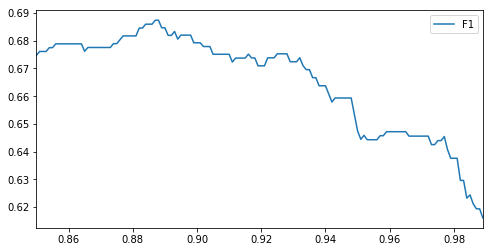

In [117]:
to_use = complete
ser = pd.DataFrame()
for i in range(850, 990, 1):
    t = i / 1000.0
    recall = recall_score((to_use.specificity_recommended >= t),
                   to_use.should_recommend)
    precision = precision_score((to_use.specificity_recommended >= t),
                   to_use.should_recommend)
    f1 = f1_score((to_use.specificity_recommended >= t),
                   to_use.should_recommend)
    ser[t] = [f1]

ser = ser.T
ser.columns = ['F1']
ser.plot()

In [86]:
df.loc[df.f1 >= 0.75].recall.round(2).min()

0.60999999999999999